## **Name:** Kaden Nguyen

## **Computing ID:** ync5ad

In [1]:
!pip install ucimlrepo
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=71f4041add73caa1b30a8e3a375dc3462e49739c93d93e618add1f64c47a40df
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn import metrics
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, silhouette_score, precision_score, recall_score, accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.cluster import KMeans
from lime import lime_tabular
from sklearn.inspection import permutation_importance
import warnings
warnings.filterwarnings('ignore')

from ucimlrepo import fetch_ucirepo

In [3]:
drug_consumption_quantified = fetch_ucirepo(id=373)
X = drug_consumption_quantified.data.features
y = drug_consumption_quantified.data.targets

In [4]:
#Remove rows with semeron reporting users
combined_df = pd.concat([X, y], axis=1)
filtered_df = combined_df[combined_df['semer'] == 'CL0']

X = filtered_df[X.columns]
y = filtered_df[y.columns]
y = y[['cannabis']]

In [5]:
X.rename(columns={
 'age': 'Age_Group',
 'gender': 'Gender',
 'education': 'Education_Level',
 'country': 'Country_of_Residence',
 'ethnicity': 'Ethnicity',
 'nscore': 'Neuroticism_Score',
 'escore': 'Extraversion_Score',
 'oscore': 'Openness_Score',
 'ascore': 'Agreeableness_Score',
 'cscore': 'Conscientiousness_Score',
 'impuslive': 'Impulsiveness_Score',
 'ss': 'Sensation_Seeking_Score',
}, inplace=True)

y.rename(columns={'cannabis': 'Cannabis_Usage_Level'}, inplace=True)

In [6]:
label_encoder = LabelEncoder()
y['Cannabis_Usage_Level'] = label_encoder.fit_transform(y['Cannabis_Usage_Level'])

In [7]:
pca = PCA(n_components=12)
X_pca = pca.fit_transform(X)

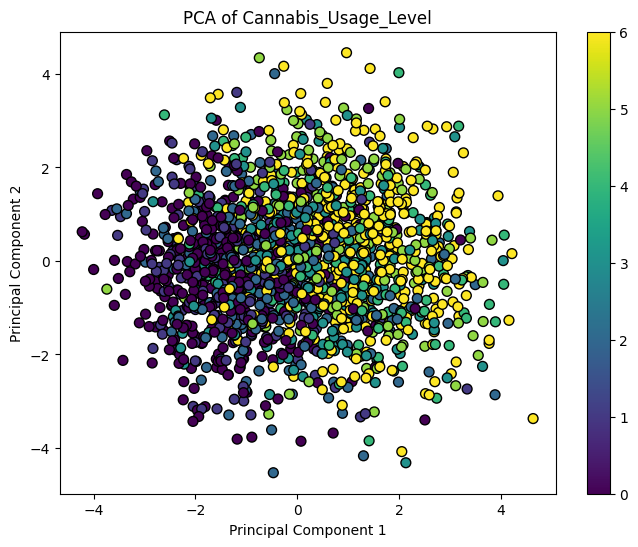

In [8]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y['Cannabis_Usage_Level'], cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Cannabis_Usage_Level')
plt.colorbar(scatter)
plt.show()

<Figure size 1200x800 with 0 Axes>

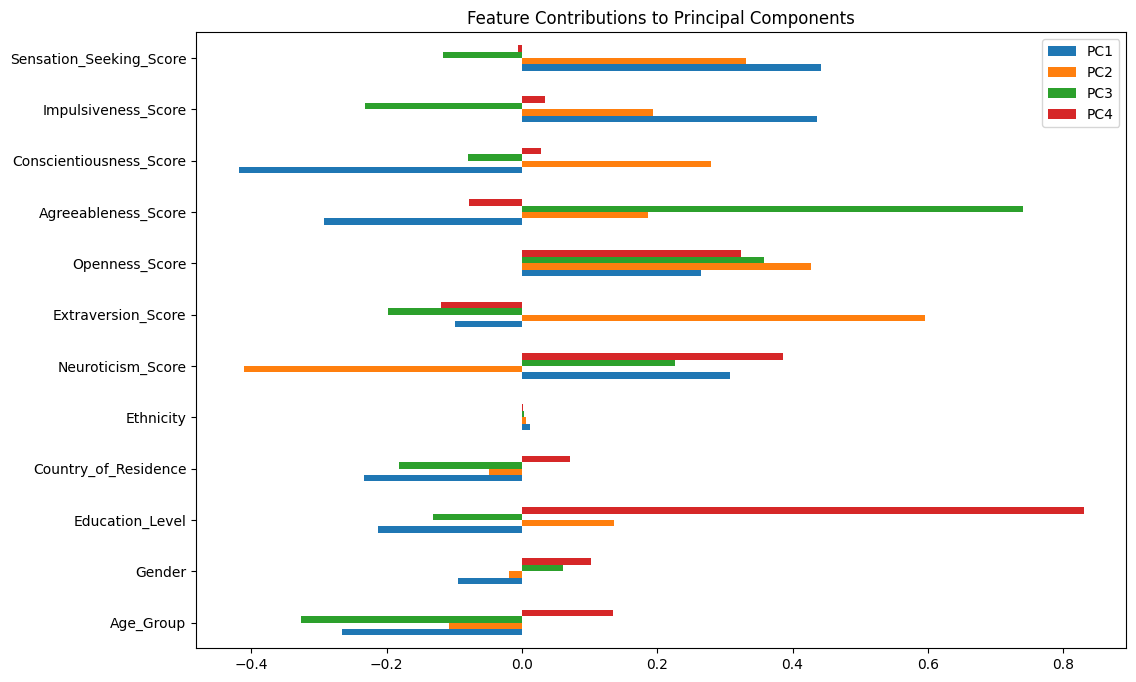

In [9]:
loadings = pd.DataFrame(
    pca.components_.T[:, 0:4],
    columns=['PC1', 'PC2', 'PC3', 'PC4'],
    index=X.columns
)

plt.figure(figsize=(12, 8))
loadings.plot(kind='barh', figsize=(12, 8))
plt.title('Feature Contributions to Principal Components')
plt.show()

In [10]:
X.describe() #Numeric values already normalized and scaled, categorical values encoded

,Age_Group,Gender,Education_Level,Country_of_Residence,Ethnicity,Neuroticism_Score,Extraversion_Score,Openness_Score,Agreeableness_Score,Conscientiousness_Score,Impulsiveness_Score,Sensation_Seeking_Score
count,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000,1877.000000
mean,0.037577,-0.000771,-0.000984,0.358984,-0.309728,-0.000551,-0.001951,-0.003224,-0.000657,-0.000394,0.005293,-0.007408
std,0.878387,0.482588,0.949831,0.699707,0.166220,0.998442,0.997418,0.995691,0.996689,0.997657,0.954148,0.962074
min,-0.951970,-0.482460,-2.435910,-0.570090,-1.107020,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,-0.951970,-0.482460,-0.611130,-0.570090,-0.316850,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,-0.078540,-0.482460,-0.059210,0.960820,-0.316850,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,0.497880,0.482460,0.454680,0.960820,-0.316850,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,2.591710,0.482460,1.984370,0.960820,1.907250,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


In [11]:
def transform_cannabis(val):
    if val in [1, 2, 3]: # Over a decade ago, Last decade, last year
        return 1
    elif val in [4, 5, 6]: # Last month, week, day
        return 2
    else: #0, never used
        return val

y['Cannabis_Usage_Level'] = y['Cannabis_Usage_Level'].apply(transform_cannabis)

In [12]:
y.head()

,Cannabis_Usage_Level
0,0
1,2
2,1
3,1
4,1


In [13]:
pca = PCA(n_components=12)
X_pca = pca.fit_transform(X)

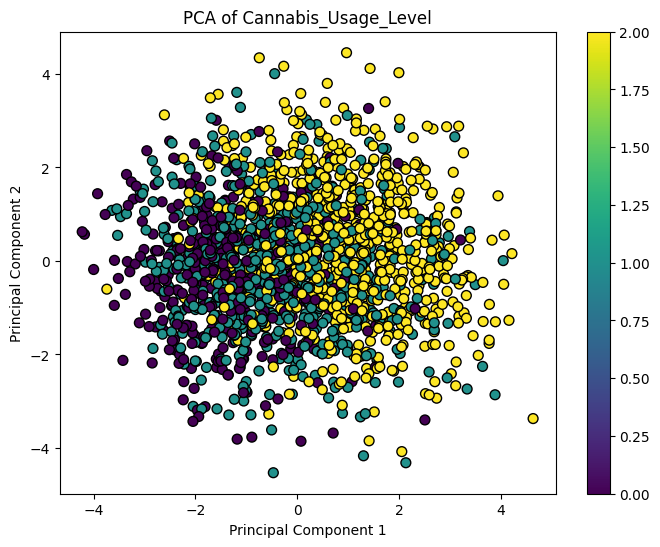

In [14]:
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y['Cannabis_Usage_Level'], cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Cannabis_Usage_Level')
plt.colorbar(scatter)
plt.show()

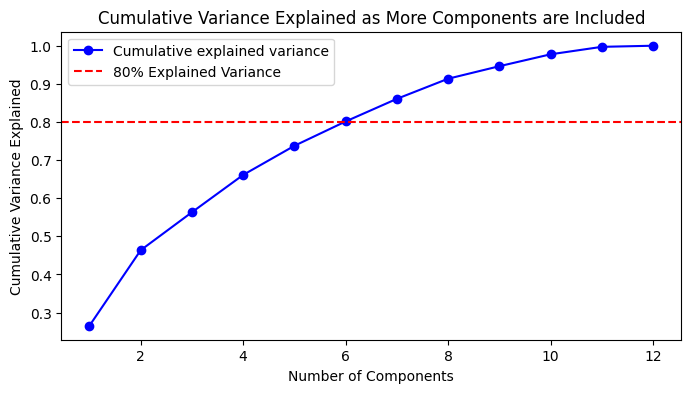

In [15]:
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 4))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='-', color='b', label='Cumulative explained variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.title('Cumulative Variance Explained as More Components are Included')
plt.axhline(y=0.80, color='r', linestyle='--', label='80% Explained Variance')
plt.legend()
plt.show()

<Figure size 1200x800 with 0 Axes>

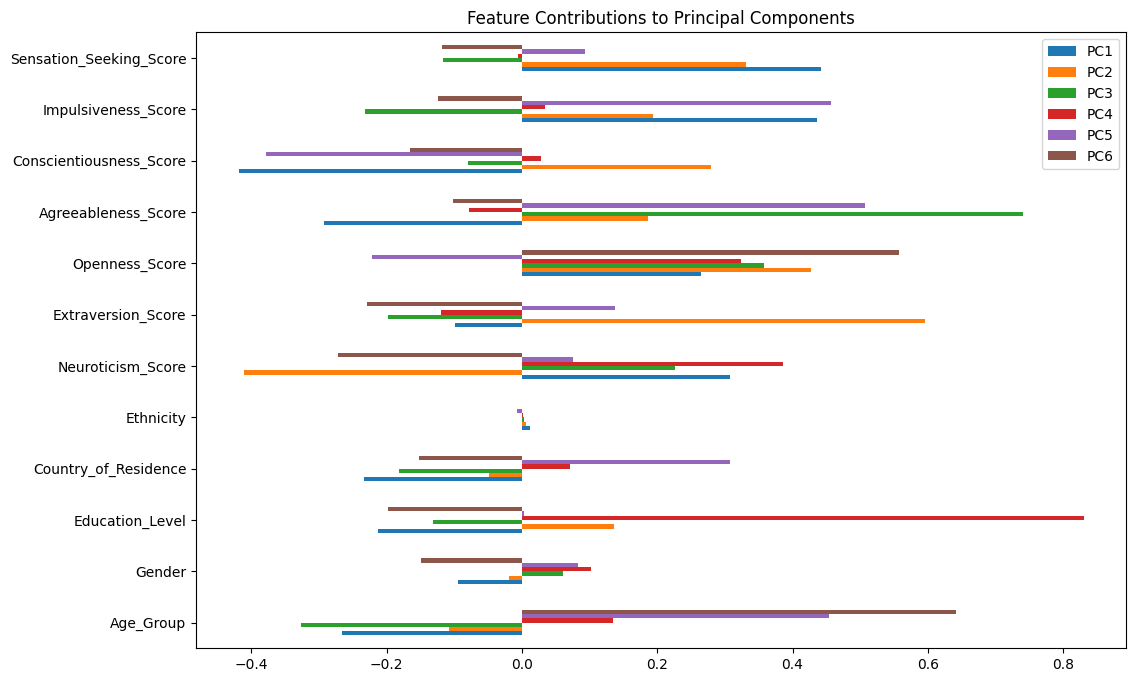

In [16]:
loadings = pd.DataFrame(
    pca.components_.T[:, 0:6],
    columns=['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6'],
    index=X.columns
)

plt.figure(figsize=(12, 8))
loadings.plot(kind='barh', figsize=(12, 8))
plt.title('Feature Contributions to Principal Components')
plt.show()

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3001)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"Default KNN F1 Score: {f1}")

Default KNN F1 Score: 0.5791065542887827


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3001)

neighbors_list = range(1, 30)

best_f1 = 0
best_k = None

for k in neighbors_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    if f1 > best_f1:
        best_f1 = f1
        best_k = k

print(f"Best n_neighbors: {best_k} with F1 Score: {best_f1:.4f}")


Best n_neighbors: 18 with F1 Score: 0.6197


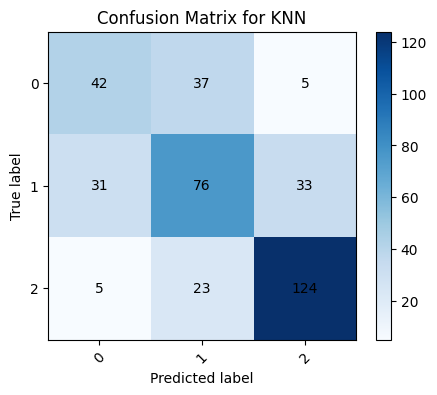

In [19]:
knn_best = KNeighborsClassifier(n_neighbors=best_k)
knn_best.fit(X_train, y_train)
y_pred = knn_best.predict(X_test)

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for KNN')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
labels = [0, 1, 2]
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.grid(False)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center", color="black")
plt.show()

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3001)

rf = RandomForestClassifier(random_state=3001)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
print(f"Default Random Forest F1 Score: {f1}")

Default Random Forest F1 Score: 0.5910497799386688


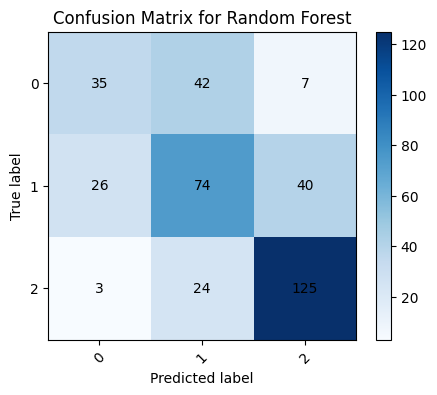

In [21]:
y_pred = rf.predict(X_test)

cm_rf = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5, 4))
plt.imshow(cm_rf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forest')
plt.colorbar()
tick_marks = np.arange(len(np.unique(y_test)))
labels = [0, 1, 2]
plt.xticks(tick_marks, labels, rotation=45)
plt.yticks(tick_marks, labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.grid(False)
for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        plt.text(j, i, cm_rf[i, j], ha="center", va="center", color="black")
plt.show()

In [22]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3001)

param_grid = {
    'criterion': ['entropy', 'gini'],
    'n_estimators': [50, 100, 150, 200, 300, 400, 500],
    'max_depth': list(range(3, 20, 2))
}

rf = RandomForestClassifier(random_state=3001)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test)
f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)

print(f"Optimized Random Forest F1 Score: {f1:.4f}")
print(f"Best Parameters: {grid_search.best_params_}")


Optimized Random Forest F1 Score: 0.5907
Best Parameters: {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 50}
